import libraries

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.constants import G,c
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u

loading the dataset from csv file.

In [42]:
df = pd.read_csv('./Skyserver_SQL6_29_2025 4_28_50 PM.csv')

calculate the average spectroscopic Redshift (specz) for each object


calculating the average specz for each id

In [43]:
averaged_df = df.groupby('objid').agg({'specz':'mean','ra':'first','dec':'first','proj_sep':'first','rmag': 'first'}).reset_index()
averaged_df.describe()['specz']

count    92.000000
mean      0.080838
std       0.008578
min       0.069976
25%       0.077224
50%       0.080961
75%       0.082797
max       0.150886
Name: specz, dtype: float64

plot the distribution of redshift as histogram and a boxplot

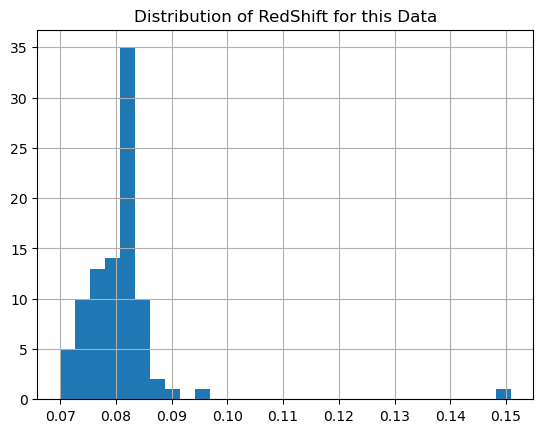

In [44]:
plt.title("Distribution of RedShift for this Data")
plt.hist(averaged_df['specz'],bins=30)
plt.grid()
plt.show()

This cell computes the mean and standard deviation of the redshift values to analyze the data distribution. It defines redshift intervals corresponding to 1σ, 2σ, and 3σ deviations from the mean, using the 3σ range to identify potential cluster members. Finally, it visualizes the redshift distribution, highlighting the mean and each sigma boundary with vertical lines for clear interpretation.

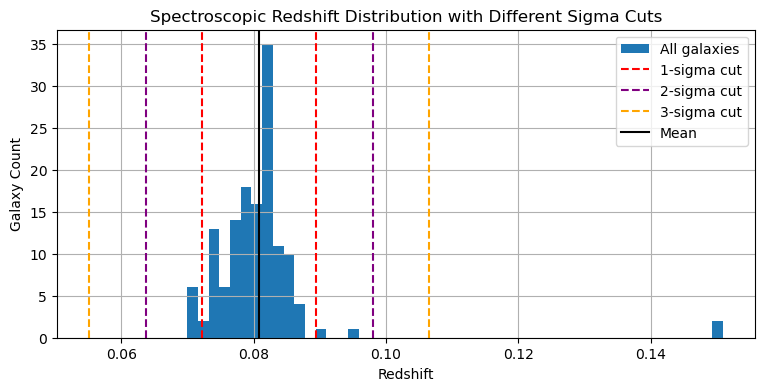

In [45]:
### Identify Cluster Members Using 3-Sigma Cut
mean_z = averaged_df['specz'].mean()
std_z = averaged_df['specz'].std()
# 1-sigma cut (originally 3-sigma in the user code)
z_min_1sigma = mean_z - 1 * std_z
z_max_1sigma = mean_z + 1 * std_z
# 2-sigma cut
z_min_2sigma = mean_z - 2 * std_z
z_max_2sigma = mean_z + 2 * std_z
# 3-sigma cut
z_min_3sigma = mean_z - 3 * std_z
z_max_3sigma = mean_z + 3 * std_z

# Identify cluster members for 3 sigma cut
cluster_members = averaged_df[(averaged_df['specz'] >= z_min_3sigma) & (averaged_df['specz'] <= z_max_3sigma)].copy()
# Plotting the distribution with different sigma cuts
plt.figure(figsize=(9, 4))
plt.hist(df['specz'], bins=50, label='All galaxies')
# Plot 1-sigma cut
plt.axvline(z_min_1sigma, color='red', linestyle='--', label='1-sigma cut')
plt.axvline(z_max_1sigma, color='red', linestyle='--')
# Plot 2-sigma cut
plt.axvline(z_min_2sigma, color='purple', linestyle='--', label='2-sigma cut')
plt.axvline(z_max_2sigma, color='purple', linestyle='--')
# Plot 3-sigma cut
plt.axvline(z_min_3sigma, color='orange', linestyle='--', label='3-sigma cut')
plt.axvline(z_max_3sigma, color='orange', linestyle='--')
plt.axvline(mean_z, color='black', linestyle='-', label='Mean')
plt.legend()
plt.title('Spectroscopic Redshift Distribution with Different Sigma Cuts')
plt.xlabel('Redshift')
plt.ylabel('Galaxy Count')
plt.grid(True)
plt.show()

1. Calculating the peculiar velocities of identified cluster members based on their redshifts.
2. Displaying the cluster’s average redshift, a sample of member velocities, and the computed velocity dispersion.
3. Visualizing the distribution of peculiar velocities through a detailed plot.

Cluster Redshift: 0.08007

Peculiar Velocity:
       specz     velocity
0  0.082457   662.365302
1  0.081218   319.185348
2  0.079564  -139.779039
3  0.080842   214.746305
4  0.084575  1248.541035

Velocity Dispersion: 1218.4929 km/s



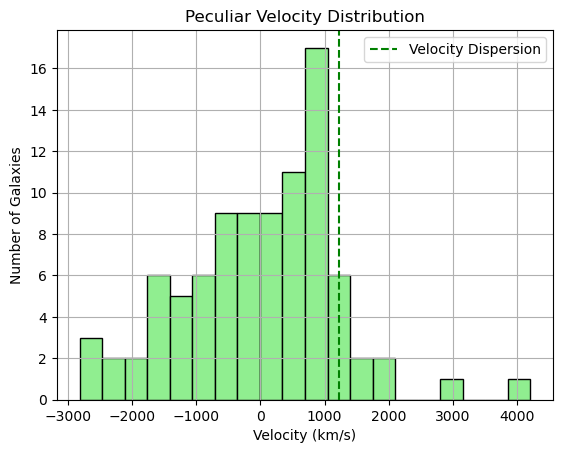

In [46]:
z = cluster_members['specz']
z_cluster = cluster_members['specz'].mean()
# Relativistic velocity calculation
numerator = (1 + z)**2 - (1 + z_cluster)**2
denominator = (1 + z)**2 + (1 + z_cluster)**2
cluster_members['velocity'] = c.value * (numerator / denominator) /1000
print(f"Cluster Redshift: {z_cluster:.5f}\n")
print("Peculiar Velocity:\n", cluster_members[['specz', 'velocity']].head())
velocity_dispersion = cluster_members['velocity'].std()
print(f"\nVelocity Dispersion: {velocity_dispersion:.4f} km/s\n")
plt.hist(cluster_members['velocity'], bins=20, color='lightgreen', edgecolor='black')
plt.axvline(velocity_dispersion, color='green', linestyle='--', label='Velocity Dispersion')
plt.title("Peculiar Velocity Distribution")
plt.xlabel("Velocity (km/s)")
plt.ylabel("Number of Galaxies")
plt.legend()
plt.grid(True)
plt.show()

This cell estimates the angular diameter distance to the cluster using a Taylor expansion approximation within a specified cosmological model. Using this distance and the 90th percentile of the projected angular separations, it then calculates the cluster's physical radius.



In [47]:
# Cluster redshift
z = cluster_members['specz'].mean()
# Hubble constant
H0 = cosmo.H(0) # Hubble constant in (km/s)/Mpc
H0_si = H0.to('1/s').value # Convert to 1/s
# Deceleration parameter
q0 = -0.534
# Speed of light in m/s
c_val = c.value
# Co-moving distance using Taylor expansion
r = (c.value * z / H0_si) * (1 - (z / 2) * (1 + q0)) # in meters
# Angular diameter distance
D_A = r / (1 + z)
# Convert to Mpc
D_A_Mpc = D_A / 3.0857e22
print(f"Angular Diameter Distance: {D_A_Mpc:.2f} Mpc")
angular_radius_arcmin = cluster_members['proj_sep'].quantile(0.9)
theta_rad = angular_radius_arcmin * np.pi / (180 * 60)
# Physical cluster radius
r_mpc = D_A_Mpc * theta_rad
print(f"Estimated Physical Cluster Radius: {r_mpc:.2f} Mpc")

Angular Diameter Distance: 322.34 Mpc
Estimated Physical Cluster Radius: 0.87 Mpc


Visualizing the distribution of projected angular separations among cluster members to analyze their spatial spread.

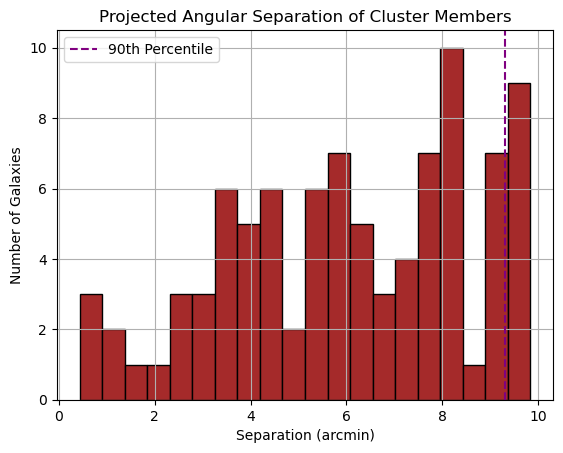

In [48]:
plt.hist(cluster_members['proj_sep'], bins=20, color='brown', edgecolor='black')
plt.axvline(angular_radius_arcmin, color='purple', linestyle='--', label='90th Percentile')
plt.title("Projected Angular Separation of Cluster Members")
plt.xlabel("Separation (arcmin)")
plt.ylabel("Number of Galaxies")
plt.legend()
plt.grid(True)
plt.show()

Estimating the cluster’s dynamical mass using the virial theorem, followed by converting the result into solar mass units for astrophysical interpretation.

In [49]:
### Estimate Dynamical Mass
sigma_m_per_s = velocity_dispersion * 1000 # km/s to m/s
R_m = r_mpc * 3.0857e22 # Mpc to meters
# Virial mass estimate in kg
mass_kg = (3 * sigma_m_per_s**2 * R_m) / G.value
# Convert to solar masses
solar_mass_kg = 2*10**30
mass_solar = mass_kg / solar_mass_kg
print(f"Dynamical Mass of Cluster: {mass_solar:.2e} M☉")

Dynamical Mass of Cluster: 8.99e+14 M☉


Computing the luminous mass of the cluster using its total luminosity and an assumed mass-to-light ratio.
Comparing the luminous mass with the dynamical mass to evaluate the cluster's mass composition and possible dark matter presence.

In [50]:
# Get luminosity distance in parsecs
z_cluster = cluster_members['specz'].mean()
D_L_pc = cosmo.luminosity_distance(z_cluster).to('pc').value
# Convert apparent to absolute magnitude
m_r = cluster_members['rmag']
M_r = m_r - 5 * np.log10(D_L_pc / 10)
# Compute luminosity relative to Sun
M_r_sun = 4.67
luminosities = 10 ** (-0.4 * (M_r - M_r_sun))
# Estimate luminous mass with M/L = 10
M_L_ratio = 10
luminous_mass = np.sum(luminosities) * M_L_ratio
print(f"Luminous Mass Estimate: {luminous_mass:.2e} M☉")
print("Mass ratio Mdyn/Mlum = ", mass_solar/luminous_mass)

Luminous Mass Estimate: 2.36e+13 M☉
Mass ratio Mdyn/Mlum =  38.155046259236066


Dynamical Mass (M₍dyn₎): 9.00 × 10¹⁴ M☉
Luminous Mass (M₍lum₎): 2.36 × 10¹³ M☉

Fraction of Luminous Mass:
f₍lum₎ = M₍lum₎ / M₍dyn₎ = (2.36 × 10¹³) / (9.00 × 10¹⁴) ≈ 0.0262

Interpretation:
Only 2.62% of the cluster’s total mass is in the form of luminous matter. The remaining 97.38% is invisible, likely composed of non-luminous hot gas or dark matter.